In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

#read data
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

## Functions

In [2]:
def to_season(month):
    '''
    Convert month to season by [winter, spring, summer, fall] -> [0,1,2,3]
    '''
    if month in [12,1,2]:
        return 0
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    else: 
        return 3

In [3]:
def convert_to_yyyymmdd(dataframe, column_name, seperator = '-', date_formate : list = ['year', 'month', 'day'], drop_org = False):
    '''
    seperator is the charactor that seperate day, month, year in the original column
    date_formats gives a list with the order of year, month, day of original column
    drop_org gives whether the function needs to 
    '''
    for i, form in enumerate(date_formate): 
        dataframe[form] = dataframe[column_name].apply(lambda date: date.split(seperator)[i])
    dataframe['season'] = dataframe['month'].apply(lambda month: to_season(int(month)))
    if drop_org:
        dataframe.drop(column_name)
    return dataframe

## A look of the data

### In Calendar file, there are 3181 lodging with records from 2016-01-04 to 2017-01-03
price would be NaN if available is f


In [4]:
calendar.head() 
calendar.date.value_counts().sort_index() #find the date range and lodging amount

2016-01-04    3818
2016-01-05    3818
2016-01-06    3818
2016-01-07    3818
2016-01-08    3818
              ... 
2016-12-29    3818
2016-12-30    3818
2016-12-31    3818
2017-01-01    3818
2017-01-02    3818
Name: date, Length: 365, dtype: int64

In [5]:
calendar = convert_to_yyyymmdd(calendar, 'date')

In [6]:
calendar['season'].value_counts()

1    351256
2    351256
3    347438
0    343620
Name: season, dtype: int64

In [7]:
#replace available variable to 0 / 1
calendar['available'] = calendar['available'].apply(lambda x:1 if x=='t' else 0) 

In [8]:
calendar_available_permonth = calendar.groupby('month').mean('available')
calendar_available_permonth.reset_index(inplace=True)

In [9]:
calendar_available_perlisting = calendar.groupby('listing_id').mean()['available']
calendar_available_perlisting = pd.DataFrame(calendar_available_perlisting).reset_index()

##### A line plot showing the trend of available rate over months

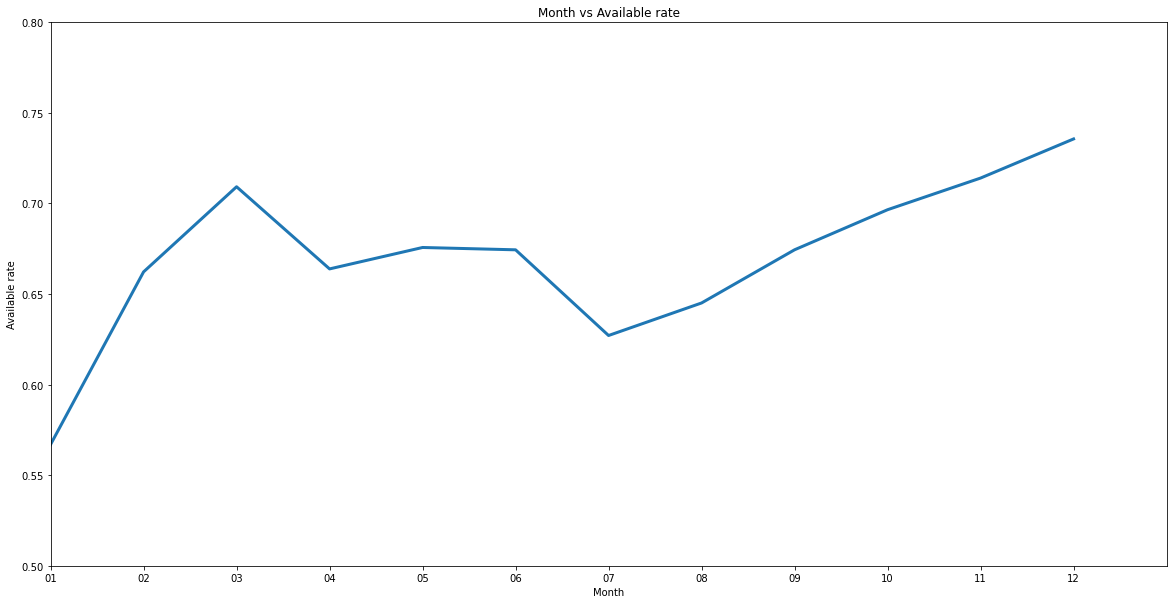

In [10]:
plt.figure(figsize=(20, 10))
x = calendar_available_permonth['month']
y = calendar_available_permonth['available']
plt.plot(x,y,linewidth=3.0)
plt.xlabel('Month', )
plt.ylabel('Available rate')
plt.title('Month vs Available rate')
plt.axis([0, 12, 0.5, 0.8])
plt.grid(False)
plt.savefig('Available rate by month.png')
plt.show()

In [11]:
calendar_available_perseason = calendar.groupby('season').mean('available')
calendar_available_perseason.reset_index(inplace=True)
calendar_available_perseason

,season,listing_id,available
0,0,5.550111e+06,0.655721
1,1,5.550111e+06,0.683109
2,2,5.550111e+06,0.648567
3,3,5.550111e+06,0.694984


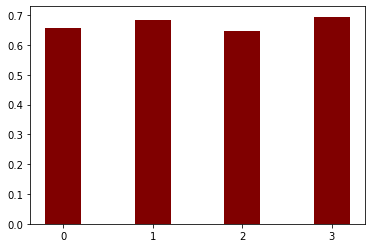

In [12]:
x = calendar_available_perseason.season
xi = list(range(len(x)))
y = calendar_available_perseason.available
plt.bar(xi, y, color ='maroon', width = 0.4)
plt.xticks(np.arange(0, 4, step=1))
plt.show()

### In listings file, we are interest in price related and review related column
There are 90 variable describe the 3181 lodging, want to learn information like location, house size, lodging type and etc. 

In [13]:
listings.isna().mean().sort_values()

id                  0.000000
price               0.000000
amenities           0.000000
bed_type            0.000000
accommodates        0.000000
                      ...   
weekly_price        0.473808
security_deposit    0.511262
monthly_price       0.602672
square_feet         0.974594
license             1.000000
Length: 92, dtype: float64

#### Clean data, fill na and convert data type

In [14]:
#remove column that contain more than 80% NaN / Null
listings = listings.drop(listings.columns[listings.isna().mean() > 0.80], axis = 1)

In [15]:
#convert price related column to float and fill NaN to $0 
col_price = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for col in col_price:
    listings[col] = listings[col].str.replace('[\$,]', '', regex=True).astype('float64').fillna(0)
listings[col_price]

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,0.0,0.0,0.0,0.0,5.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0
2,975.0,0.0,0.0,1000.0,300.0,25.0
3,100.0,650.0,2300.0,0.0,0.0,0.0
4,450.0,0.0,0.0,700.0,125.0,15.0
...,...,...,...,...,...,...
3813,359.0,0.0,0.0,0.0,230.0,0.0
3814,79.0,0.0,0.0,500.0,50.0,25.0
3815,93.0,450.0,0.0,250.0,35.0,20.0
3816,99.0,0.0,0.0,300.0,45.0,0.0


In [16]:
#find review column
col_review = listings.columns[listings.columns.str.startswith('review')]
listings[listings[col_review].isna().all(axis = 1)].shape[0]

627

In [17]:
#convert rate column to numeric
col_rate = listings.columns[listings.columns.str.endswith('rate')]
for col in col_rate:
    listings[col] = listings[col].fillna(listings[col].mode()[0]).str.replace('%', '').astype('float64').apply(lambda row: row / 100)

In [18]:
#get rid of the column with only one category
col_category = listings.select_dtypes('object').columns.tolist()
for col in col_category:
    if len(pd.unique(listings[col].str.lower())) == 1:
        listings = listings.drop(col, axis = 1)
        col_category.remove(col)

In [19]:
listings.select_dtypes(['int64','float64']).columns

Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [20]:
#replace f, t to 0, 1
col_binary = []
for col in col_category:
    if 'f' in pd.unique(listings[col].str.lower()):
        col_binary.append(col)
        listings[col] = listings[col].apply(lambda x:1 if x=='t' else 0)

### Find the distribution

In [21]:
max(listings['price'])

1000.0

##### The zipcode versus location review

In [22]:
listings['zipcode'] = listings['zipcode'].replace('99\n98122', '98122') #modify content
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'name', 'summary', 'space',
       'description', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'zipcode', 'smart_location',
       'country', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'clean

In [23]:
col_interest = ['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'price', 'house size']

In [24]:
# create the table of counts of the zipcode and average review
zipcode_counts = listings.zipcode.value_counts().sort_index()

# converting to df and assigning new names to the columns
df_zipcode_counts = pd.DataFrame(zipcode_counts)
df_zipcode_counts = df_zipcode_counts.reset_index()
df_zipcode_counts.columns = ['zipcode', 'counts'] # change column names
df_zipcode_counts['average_review'] = listings[['zipcode','review_scores_location']].groupby('zipcode').mean().reset_index()['review_scores_location']

In [25]:
# 98118	154	9.000000
df_zipcode_counts = df_zipcode_counts.sort_values('average_review', ascending= False)

In [26]:
df_zipcode_counts

,zipcode,counts,average_review
0,98101,201,9.877907
11,98116,112,9.877778
15,98121,196,9.837209
9,98112,167,9.804348
1,98102,339,9.790441
2,98103,394,9.771341
6,98107,180,9.769737
14,98119,143,9.731092
8,98109,202,9.723270
21,98136,44,9.722222


#### hard to see the trend with line chart

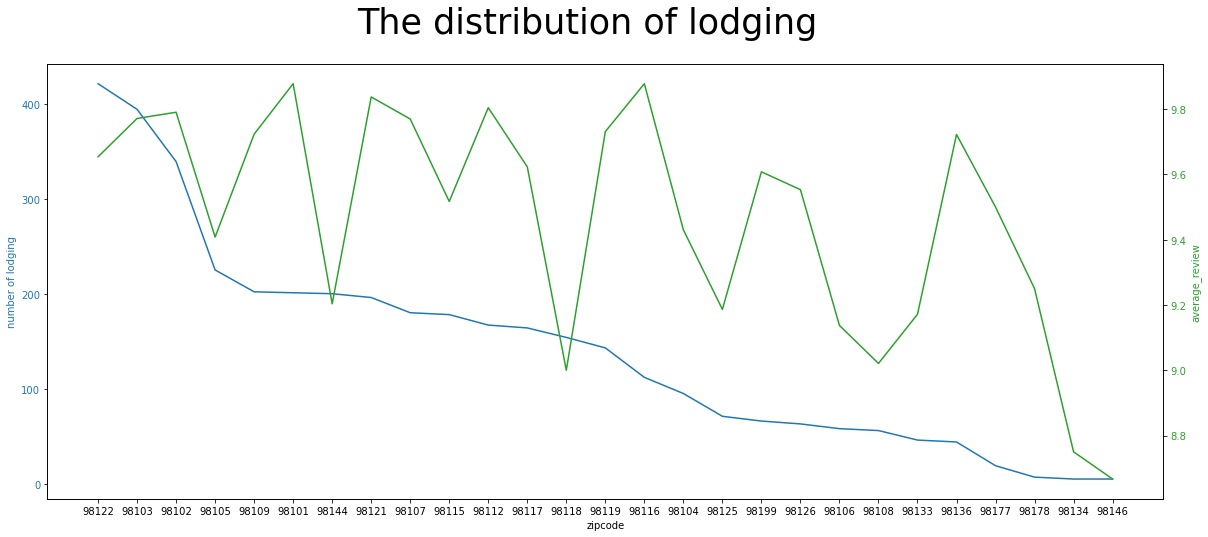

<Figure size 1440x720 with 0 Axes>

In [27]:
fig, ax1 = plt.subplots(figsize=(20, 8))

plt.figure(figsize=(20, 10))
x = df_zipcode_counts.sort_values('counts',ascending= False)['zipcode']
y = df_zipcode_counts.sort_values('counts',ascending= False)['counts']
y2 = df_zipcode_counts.sort_values('counts',ascending= False)['average_review']

color = 'tab:blue'
ax1.set_xlabel('zipcode')
ax1.set_ylabel('number of lodging', color = color)
ax1.plot(x, y, color = color)
ax1.tick_params(axis ='y', labelcolor = color)
  
ax2 = ax1.twinx()
  
color = 'tab:green'
ax2.set_ylabel('average_review', color = color)
ax2.plot(x, y2, color = color)
ax2.tick_params(axis ='y', labelcolor = color)
  
fig.suptitle('The distribution of lodging', fontweight ="regular", fontsize = 35)
plt.show()

#### availability per zipcode

In [28]:
listings = listings.join(calendar_available_perlisting, lsuffix = 'id', rsuffix='listing_id')

In [29]:
listings.groupby('zipcode').mean()['available'].to_csv('zipcode_available.csv')

#### house features: room number, bathrooms, beds, amenities etc. 

In [30]:
#take the number of amenities as one of the house features 
listings['amenities_counts'] = listings['amenities'].str.replace('[{}]', '', regex=True).apply(lambda x: len(x.split(',')))

In [31]:
amenities_list = listings['amenities'].str.replace('[{"}]', '', regex=True).apply(lambda x: x.split(','))
amenities = []
for row in amenities_list:
    amenities = list(set(amenities + row))
amenities.remove('')
# test = 0
# while test < 6:
#     print(listings['amenities'][test].split(','))
#     test += 1
# for row in listings['amenities']: 

In [32]:
# import pprint
# pp = pprint.PrettyPrinter(width=80, compact=True)
# pp.pprint(amentities)
amenities.sort(key = len)
pd.DataFrame(amenities).to_excel('amenities.xlsx')

In [42]:
listings.describe()['amenities_counts']

count    3818.000000
mean       14.370613
std         4.706825
min         1.000000
25%        11.000000
50%        14.000000
75%        17.000000
max        30.000000
Name: amenities_counts, dtype: float64

### Correlation with price

In [34]:
col_id = listings.columns[listings.columns.str.endswith('id')]
listings.select_dtypes(['int64','float64']).drop(col_binary+list(col_review)+list(col_id),axis = 1).corr()['price'].sort_values(ascending = False)

price                             1.000000
accommodates                      0.652218
bedrooms                          0.627720
beds                              0.589525
cleaning_fee                      0.576423
bathrooms                         0.516424
weekly_price                      0.394486
guests_included                   0.392875
security_deposit                  0.333579
monthly_price                     0.275787
amenities_counts                  0.184176
extra_people                      0.127961
host_total_listings_count         0.093962
host_listings_count               0.093962
minimum_nights                    0.017297
available                         0.006495
host_acceptance_rate              0.005915
host_response_rate                0.002146
maximum_nights                   -0.003336
latitude                         -0.008904
availability_365                 -0.015550
availability_30                  -0.037653
availability_60                  -0.049336
calculated_

In [35]:
listings['price_per_person'] = listings['price']/listings['accommodates']

### Type of lodgings

In [36]:
listings.groupby(listings['property_type']).mean()['price_per_person'].sort_values(ascending = False)

property_type
Boat               84.682292
Treehouse          59.666667
Bed & Breakfast    56.828829
Loft               50.144167
Condominium        48.307143
Chalet             47.875000
Cabin              43.996032
Camper/RV          43.820513
Apartment          43.276326
Bungalow           43.050000
Other              41.795455
Townhouse          39.901168
House              38.249583
Yurt               33.333333
Tent               28.750000
Dorm                4.937500
Name: price_per_person, dtype: float64

In [43]:
listings.select_dtypes(['int64','float64']).drop(col_binary+list(col_review)+list(col_id),axis = 1).corr()['price_per_person'].sort_values(ascending = False)

price_per_person                  1.000000
price                             0.450056
weekly_price                      0.130275
security_deposit                  0.061220
monthly_price                     0.059170
availability_365                  0.030469
bathrooms                         0.024170
host_response_rate                0.018060
cleaning_fee                      0.017096
availability_30                   0.013015
available                         0.004578
availability_60                   0.000509
minimum_nights                    0.000373
availability_90                  -0.002546
host_listings_count              -0.002917
host_total_listings_count        -0.002917
maximum_nights                   -0.003295
host_acceptance_rate             -0.004880
extra_people                     -0.015755
latitude                         -0.018131
calculated_host_listings_count   -0.043426
longitude                        -0.045830
bedrooms                         -0.070053
amenities_c